In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
import scipy
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import random
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score


Bad key text.latex.preview in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [2]:
warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv('./data/townhouse_data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59026 entries, 0 to 59025
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Floor                            59026 non-null  float64
 1   Building_Age                     59026 non-null  int64  
 2   JS_BA                            59026 non-null  float64
 3   Population                       59026 non-null  int64  
 4   IR                               59026 non-null  float64
 5   LC_index                         59026 non-null  float64
 6   CA_index                         59026 non-null  float64
 7   TC_index                         59026 non-null  float64
 8   SDT_index                        59026 non-null  float64
 9   Crime_Rates                      59026 non-null  float64
 10  latitude                         59026 non-null  float64
 11  longitude                        59026 non-null  float64
 12  Sell_Price        

## Categorical:

- Nominal(variables that have two or more categories, but which do not have an intrinsic order.)

    - Region_Name : 자치구 명
    - Building_Use : 건물 용도
    
- Ordinal(variables that have two or more categories just like nominal variables. Only the categories can also be ordered or ranked.)

    
## Numeric:

- Discrete
    - YearMonth : 년월
    - Building_Age : 건물연식
    - JS_Price : 전세가
   
- Continous
    - Sell_Price : 매매 가격
    - JS_BA = JS_Building Area : 임대 면적
    - lR = Interest Rate : 금리
    - UR = Unemployment Rate : 실업률
    - LC_index = Leading Composite index : 선행종합 지수
    - CA_index = Comprehensive Accompany index : 동행종합 지수
    - TC_index = Trailing Composite index : 후행종합 지수
    - SDT_index = Supply and Demand Trend index = 전세수급동향 지수
    - HSP_index = 
    - Population : 인구수
    - Crime_Rates : 범죄율
    - Shortest_Distance_to_Subway : 가장 가까운 지하철역과의 거리
    - Shortest_Distance_to_School : 가장 가까운 초중고등학교와의 거리
    - Shortest_Distance_to_Univ : 가장 가까운 대학교와의 거리
    - Shortest_Distance_to_Park : 가장 가까운 공원과의 거리
    

## 데이터 전처리

In [5]:
# 범주형 변수 리스트 지정
categorical_columns = ['Building_Use_y', 'Region_Name_y', 'YearMonth']
target_column = 'JS_Price'

# 데이터 분할: 학습용(train), 테스트용(test)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# 학습 데이터에서 검증용(validation) 데이터를 다시 분할
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# 각 범주형 변수에 대한 인코딩 매핑을 저장할 딕셔너리 초기화
encoding_maps = {}

# 학습 데이터에서 각 범주의 평균 타겟 값 계산 및 매핑 저장
for categorical_column in categorical_columns:
    encoding_map = train_data.groupby(categorical_column)[target_column].mean().to_dict()
    encoding_maps[categorical_column] = encoding_map

    # 학습 데이터에 타겟 인코딩 적용
    train_data[categorical_column + '_encoded'] = train_data[categorical_column].map(encoding_map)
    val_data[categorical_column + '_encoded'] = val_data[categorical_column].map(encoding_map)
    test_data[categorical_column + '_encoded'] = test_data[categorical_column].map(encoding_map)

    # 기존 범주형 변수 삭제
    train_data.drop(columns=[categorical_column], inplace=True)
    val_data.drop(columns=[categorical_column], inplace=True)
    test_data.drop(columns=[categorical_column], inplace=True)

In [6]:
# JS_Price를 4개의 범주로 나눔
train_data['JS_Price_Category'] = pd.cut(train_data['JS_Price'], bins=5, labels=False)
val_data['JS_Price_Category'] = pd.cut(val_data['JS_Price'], bins=5, labels=False)
test_data['JS_Price_Category'] = pd.cut(test_data['JS_Price'], bins=5, labels=False)

# 각 구간의 경계값을 구함
bin_edges = pd.cut(df['JS_Price'], bins=5).unique()

# 결과 출력
print("구간의 경계값:")
print(bin_edges)

# 기존 변수 삭제
train_data.drop('JS_Price', axis=1, inplace=True)
val_data.drop('JS_Price', axis=1, inplace=True)
test_data.drop('JS_Price', axis=1, inplace=True)

# 오버샘플링할 데이터와 레이블을 준비합니다.
X_train = train_data.drop('JS_Price_Category', axis=1)  # 독립변수
Y_train = train_data['JS_Price_Category']  # 종속변수
X_val = val_data.drop('JS_Price_Category', axis=1)  # 검증 독립변수
Y_val = val_data['JS_Price_Category']  # 검증 종속변수
X_test = test_data.drop('JS_Price_Category', axis=1)  # 테스트 독립변수
Y_test = test_data['JS_Price_Category']  # 테스트 종속변수

# RandomOverSampler를 초기화합니다.
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# 오버샘플링을 적용합니다(테스트 데이터는 일반화 성능 평가를 위해 적용X)
X_train_resampled, Y_train_resampled = oversampler.fit_resample(X_train, Y_train)

# 오버샘플링된 데이터를 새로운 데이터프레임으로 만듭니다.
train_data_resampled = pd.concat([X_train_resampled, Y_train_resampled], axis=1)

구간의 경계값:
[(-19.55, 94360.0], (94360.0, 188270.0], (188270.0, 282180.0], (376090.0, 470000.0], (282180.0, 376090.0]]
Categories (5, interval[float64, right]): [(-19.55, 94360.0] < (94360.0, 188270.0] < (188270.0, 282180.0] < (282180.0, 376090.0] < (376090.0, 470000.0]]


## Logistic Regression Analysis

In [7]:
selected_features = ['Population',
'HSP_index',
'YearMonth_encoded',
'Crime_Rates',
'TC_index',
'CA_index',
'SDT_index',
'Floor',
'IR',
'UR']

In [8]:
# 독립 변수 선택
X_train_resampled = train_data_resampled[selected_features]

# 테스트 데이터에 대해 동일한 특성 선택 적용
X_test = X_test[selected_features]

# 데이터 표준화 (선택적)
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# 다항 로지스틱 회귀 모델 생성
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_resampled, Y_train_resampled)

# 모델 평가 (정확도 계산)
accuracy = model.score(X_test, Y_test)
print(f"모델 정확도 : {accuracy}", '\n')

# 각 클래스에 속할 확률 예측
probabilities = model.predict_proba(X_test)

# 예측 결과 클래스 (가장 높은 확률을 갖는 클래스 선택)
predicted_classes = model.predict(X_test)

# 예측된 클래스 및 확률 출력
print("---예측된 클래스---", '\n', predicted_classes, '\n')
print("---클래스별 확률---", '\n', probabilities)

모델 정확도 : 0.6788920887684229 

---예측된 클래스--- 
 [1 0 1 ... 0 0 0] 

---클래스별 확률--- 
 [[3.10267199e-01 5.12631750e-01 1.67055153e-01 1.00458981e-02]
 [6.12783947e-01 3.87216053e-01 3.77130044e-43 5.76315667e-52]
 [4.74688655e-01 5.23545412e-01 1.76593290e-03 1.23703612e-12]
 ...
 [8.14447964e-01 1.85552036e-01 1.46463799e-34 8.41110698e-38]
 [8.00253118e-01 1.99746882e-01 2.67738956e-60 1.00836212e-68]
 [9.19405163e-01 8.05948366e-02 1.31249400e-54 3.34094959e-58]]


## 교차검증
- data leakage 확인을 위해 교차검증 실행

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

# StratifiedKFold를 사용하여 k-폴드 교차 검증 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 수행 및 결과 저장
cv_scores = []
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_resampled, Y_train_resampled), 1):
    fold_X_train, fold_X_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
    fold_Y_train, fold_Y_val = Y_train_resampled[train_idx], Y_train_resampled[val_idx]
    
    model.fit(fold_X_train, fold_Y_train)
    fold_Y_pred = model.predict(fold_X_val)
    
    fold_accuracy = model.score(fold_X_val, fold_Y_val)
    cv_scores.append(fold_accuracy)
    
    print(f"Fold {i} 정확도: {fold_accuracy}")
    print(f"Fold {i} 분류 보고서:\n{classification_report(fold_Y_val, fold_Y_pred)}")

# 교차 검증 결과 출력
print("교차 검증 정확도:", cv_scores)
print("평균 교차 검증 정확도:", sum(cv_scores) / len(cv_scores))

Fold 1 정확도: 0.8254415321912588
Fold 1 분류 보고서:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      7545
           1       0.68      0.63      0.65      7545
           2       0.97      1.00      0.98      7544
           4       0.99      1.00      0.99      7545

    accuracy                           0.83     30179
   macro avg       0.82      0.83      0.82     30179
weighted avg       0.82      0.83      0.82     30179

Fold 2 정확도: 0.8277941615030319
Fold 2 분류 보고서:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      7545
           1       0.69      0.63      0.66      7544
           2       0.96      1.00      0.98      7545
           4       0.98      1.00      0.99      7545

    accuracy                           0.83     30179
   macro avg       0.82      0.83      0.83     30179
weighted avg       0.82      0.83      0.83     30179

Fold 3 정확도: 0.83037311949102
Fold 3 분류

- 다섯 개의 fold에서 모두 비슷한 정확도를 보이고 있으므로 data leakage의 증거가 없어보임.

## Training and validaion accuracy
- 학습곡선으로 데이터 크기 증가에 따른 훈련데이터와 검증 데이터의 정확도를 그림으로써 모델의 과적합을 시각적으로 확인

In [10]:
# 검증 데이터에 대해 동일한 특성 선택 적용
X_val = val_data[selected_features]

# 검증 데이터에 대한 표준화 (선택적)
X_val = scaler.transform(X_val)

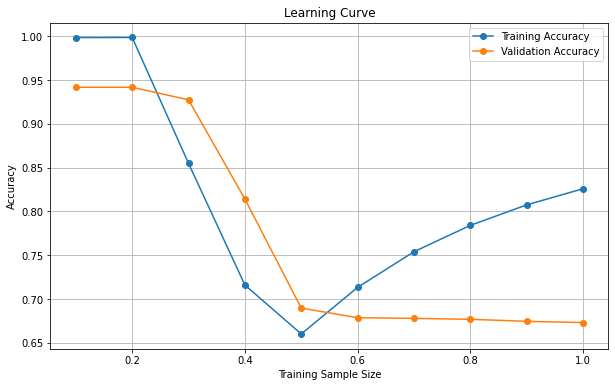

In [11]:
# 다양한 훈련 샘플 크기 설정
train_sizes = np.linspace(0.1, 1.0, 10)  # 10개의 다양한 훈련 크기

# 결과를 저장할 리스트 초기화
train_accuracy = []
val_accuracy = []

# 각 훈련 크기에 대해 모델 학습 및 평가
for train_size in train_sizes:
    # 훈련 크기에 맞게 데이터 샘플링
    num_samples = int(train_size * X_train_resampled.shape[0])
    X_train_subset = X_train_resampled[:num_samples]
    Y_train_subset = Y_train_resampled[:num_samples]
    
    # 모델 학습
    model.fit(X_train_subset, Y_train_subset)
    
    # 학습 데이터와 검증 데이터에 대한 정확도 계산
    train_pred = model.predict(X_train_subset)
    val_pred = model.predict(X_val)
    
    train_accuracy.append(accuracy_score(Y_train_subset, train_pred))
    val_accuracy.append(accuracy_score(Y_val, val_pred))

# 학습 곡선 그리기
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_accuracy, marker='o', label='Training Accuracy')
plt.plot(train_sizes, val_accuracy, marker='o', label='Validation Accuracy')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

- 0.6부터 과적합 발생하므로 0.6까지만 훈련 진행하는 모델을 다시 생성

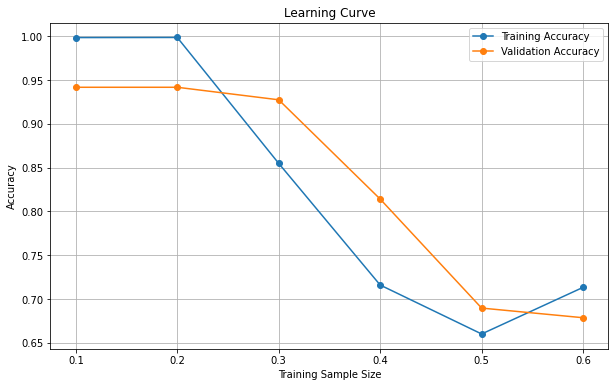

In [12]:
# 다양한 훈련 샘플 크기 설정
train_sizes = np.linspace(0.1, 0.6, 6)  # 6

# 결과를 저장할 리스트 초기화
train_accuracy = []
val_accuracy = []

# 각 훈련 크기에 대해 모델 학습 및 평가
for train_size in train_sizes:
    # 훈련 크기에 맞게 데이터 샘플링
    num_samples = int(train_size * X_train_resampled.shape[0])
    X_train_subset = X_train_resampled[:num_samples]
    Y_train_subset = Y_train_resampled[:num_samples]
    
    # 모델 학습
    model.fit(X_train_subset, Y_train_subset)
    
    # 학습 데이터와 검증 데이터에 대한 정확도 계산
    train_pred = model.predict(X_train_subset)
    val_pred = model.predict(X_val)
    
    train_accuracy.append(accuracy_score(Y_train_subset, train_pred))
    val_accuracy.append(accuracy_score(Y_val, val_pred))

# 학습 곡선 그리기
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_accuracy, marker='o', label='Training Accuracy')
plt.plot(train_sizes, val_accuracy, marker='o', label='Validation Accuracy')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

## 변수선택법
- 모델의 복잡성이 줄어든 상태에서 통계적 유의성을 고려하여 변수선택을 위해 다중공선성과 p-value 체크

### 회귀계수, 오즈비
- 양수 회귀 계수는 해당 독립 변수 값이 증가할 때 종속 변수도 증가하게 하고, 음수 회귀 계수는 해당 독립 변수 값이 감소할 때 종속 변수도 감소하게 합니다. 이때 계수의 절댓값이 클수록 종속 변수에 큰 영향을 미칩니다.
- 오즈비가 1보다 크면 해당 독립 변수가 종속변수 클래스의 확률에 긍정적인 영향을 미칩니다. 오즈비가 1보다 작으면 부정적인 영향을 미칩니다.

In [13]:
# 회귀 모델을 이미 만들었다고 가정합니다.
# model은 이미 다중 클래스 로지스틱 회귀 모델로 훈련되어 있다고 가정합니다.

# 독립 변수의 열 이름
independent_variable_names = selected_features 

# 종속 변수 열의 이름을 식별하고 고유한 클래스 값을 확인합니다.
dependent_variable_column = "JS_Price_Category"
dependent_variable_classes = train_data_resampled[dependent_variable_column].unique()

# 회귀 계수 출력
coefficients = model.coef_

# 빈 DataFrame 생성
coef_df = pd.DataFrame(columns=["종속 변수 클래스", "독립 변수", "회귀 계수", "오즈비"])

# 각 독립 변수와 종속 변수 클래스에 대한 회귀 계수와 오즈비를 DataFrame에 추가
for i, dep_class in enumerate(dependent_variable_classes):
    for j, indep_var in enumerate(independent_variable_names):
        coef = coefficients[i][j]
        odds_ratio = np.exp(coef)
        coef_df = coef_df.append({
            "종속 변수 클래스": dep_class,
            "독립 변수": indep_var,
            "회귀 계수": coef,
            "오즈비": odds_ratio
        }, ignore_index=True)

In [14]:
coef_df

,종속 변수 클래스,독립 변수,회귀 계수,오즈비
0,0,Population,0.097097,1.101967e+00
1,0,HSP_index,-13.476217,1.403955e-06
2,0,YearMonth_encoded,-0.205354,8.143587e-01
3,0,Crime_Rates,-0.560325,5.710232e-01
4,0,TC_index,1.744382,5.722366e+00
5,0,CA_index,-1.691475,1.842476e-01
6,0,SDT_index,-2.397271,9.096586e-02
7,0,Floor,0.168405,1.183415e+00
8,0,IR,-3.613009,2.697056e-02
9,0,UR,-0.289248,7.488263e-01


### 다중공선성

In [18]:
# 각 독립 변수의 VIF 계산
vif = pd.DataFrame()
vif["Features"] = X_train_subset_df.columns
vif["VIF"] = [variance_inflation_factor(X_train_subset_df.values, i) for i in range(X_train_subset_df.shape[1])]

print("독립 변수별 VIF:")
print(vif)

독립 변수별 VIF:
             Features        VIF
0               const   1.381392
1          Population   1.479139
2           HSP_index   7.154035
3   YearMonth_encoded  15.715642
4         Crime_Rates   1.512030
5            TC_index  69.007969
6            CA_index  76.029992
7           SDT_index   3.908264
8               Floor   1.107453
9                  IR   5.701563
10                 UR   1.542009


- VIF값 10을 기준으로 높으면 변수에서 제거할 요인으로 본다면 CA_index, TC_index를 제외한다(YearMonth는 중요도가 높은 변수이기 때문에 예외처리)

### P-value

In [19]:
# 독립 변수를 데이터프레임으로 변환
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=selected_features)

# CA_index와 TC_index 제거
X_train_resampled_df.drop(['CA_index', 'TC_index'], axis=1, inplace=True)

# 다항 로지스틱 회귀 모델 생성 (상수항 추가)
X_train_resampled_df = sm.add_constant(X_train_resampled_df)
model = sm.MNLogit(Y_train_resampled, X_train_resampled_df)

# 모델 피팅
result = model.fit()

# 독립 변수들의 p-value 추출
p_values = result.pvalues

# 결과 출력
print("P-values for independent variables:")
print(p_values)

Optimization terminated successfully.
         Current function value: nan
         Iterations 22
P-values for independent variables:
                               0              1              2
const               5.192142e-19   1.162198e-70  1.074815e-245
Population          0.000000e+00   7.254845e-69   7.342654e-12
HSP_index           0.000000e+00   1.649836e-98  1.717492e-114
YearMonth_encoded   0.000000e+00   1.786185e-10  2.351857e-238
Crime_Rates         0.000000e+00   0.000000e+00  7.531546e-300
SDT_index           4.353359e-88  5.292445e-178  4.447536e-161
Floor               1.816571e-19   6.202502e-87   0.000000e+00
IR                 5.383584e-271  1.790904e-235   1.572705e-24
UR                 1.181375e-305   1.187573e-46   1.520586e-57


- a=0.01일 때, p-value값을 고려하면 제거할 요인은 없다.

## 최종결론
- Features_Ranking의 상위 10가지를 제외한 나머지 변수에 대해 VIF와 Logistic Regression Analysis를 진행한다.
    - Logistit Regression의 p-value값의 제거요인은 없다.
    - VIF의 제거요인인 CA_index, TC_index
    - 위의 세가지 요인(CA_index, TC_index)을 변수에서 제거하여 머신러닝을 진행한다.